<a href="https://colab.research.google.com/github/Yeganehfrh/B2BC_hypnotic_interaction/blob/main/PLB_HYP_EEG_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OTKA1 EEG Preprocessing Notebook

This notebook produces the pre-processed EEG data as well as in-line plots for [OTKA study1](https://docs.google.com/document/d/1lrhz2cOC8AuHjjzRLslTLsh8AoPlus8UUCoQJugD5ws/edit).

It expects raw EEG data in BrainVision core data format.



# Setup

Run this before the rest.

In [ ]:
# install necessary tools
!pip install mne mne_bids pymanopt #git+https://github.com/nbara/python-meegkit.git autoreject

     |████████████████████████████████| 6.9 MB 5.2 MB/s 
     |████████████████████████████████| 852 kB 39.9 MB/s 
     |████████████████████████████████| 59 kB 7.0 MB/s 


In [ ]:
# import necessary modules
import os
import numpy as np
import mne
import os.path as op
#from mne_bids.copyfiles import copyfile_brainvision
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftshift
# from meegkit import dss
import sklearn
import joblib

# Mount Google drive

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


# Preprocessing

Preprocessing steps includes:
- Re-referencing to the average of the left and right mastoids.
- Detect and mark bad channels
- Remove line noise.
- Low-pass and high-pass filtering at 0.3 Hz and 70 Hz.
- Pick out the target segments and epoching.
- Remove bad epochs.
- Repaire biological artifact with ICA.



Following cell will first open the BrainVision data in MNE and then re-reference it to the average of mastoid channels.



## Read data and re-reference

In [ ]:
# open EEG data
raw = mne.io.read_raw_brainvision('/content/drive/MyDrive/Live Sessions/214811.vhdr', eog=('EOG1', 'EOG2'), misc= ['ECG'], preload = True)
raw.set_channel_types({'ECG':'ecg'})
# TO BE SKIPPED IN THE MAIN ANALYSIS # Downsample or crop data to speed up the computation
raw.resample(128)
#raw.crop(tmin = 360, tmax = 660)

# use average of mastoid channels as reference
#raw.set_eeg_reference(ref_channels=['M1', 'M2'])


Extracting parameters from /content/drive/MyDrive/Live Sessions/214811.vhdr...
Setting channel info structure...
Reading 0 ... 6199939  =      0.000 ...  6199.939 secs...


<ipython-input-30-5ea10d9d26ba>:3: RuntimeWarning: The unit for channel(s) ECG has changed from NA to V.
  raw.set_channel_types({'ECG':'ecg'})


<RawBrainVision | 214811.eeg, 61 x 793592 (6199.9 s), ~369.4 MB, data loaded>

## TODO: Mark bad channels
Using PSD, signal traces, 2D sensor topography as well as the information about channels' impedances, this section attempts to identify bad channels.

In [ ]:
# get the channels' impedance from header file
f = open('/content/drive/MyDrive/Live Sessions/214811.vhdr', "r")
print(f.read())

Brain Vision Data Exchange Header File Version 1.0
; Data created by the Vision Recorder

[Common Infos]
Codepage=UTF-8
DataFile=214811.eeg
MarkerFile=214811.vmrk
DataFormat=BINARY
; Data orientation: MULTIPLEXED=ch1,pt1, ch2,pt1 ...
DataOrientation=MULTIPLEXED
NumberOfChannels=61
; Sampling interval in microseconds
SamplingInterval=1000

[Binary Infos]
BinaryFormat=INT_16

[Channel Infos]
; Each entry: Ch<Channel number>=<Name>,<Reference channel name>,
; <Resolution in "Unit">,<Unit>, Future extensions..
; Fields are delimited by commas, some fields might be omitted (empty).
; Commas in channel names are coded as "\1".
Ch1=Fp1,,0.1,µV
Ch2=Fp2,,0.1,µV
Ch3=F3,,0.1,µV
Ch4=F4,,0.1,µV
Ch5=C3,,0.1,µV
Ch6=C4,,0.1,µV
Ch7=P3,,0.1,µV
Ch8=P4,,0.1,µV
Ch9=O1,,0.1,µV
Ch10=O2,,0.1,µV
Ch11=F7,,0.1,µV
Ch12=F8,,0.1,µV
Ch13=T7,,0.1,µV
Ch14=T8,,0.1,µV
Ch15=P7,,0.1,µV
Ch16=P8,,0.1,µV
Ch17=Fpz,,0.1,µV
Ch18=Fz,,0.1,µV
Ch19=Cz,,0.1,µV
Ch20=CPz,,0.1,µV
Ch21=Pz,,0.1,µV
Ch22=POz,,0.1,µV
Ch23=Oz,,0.1,µV
Ch24=Iz

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


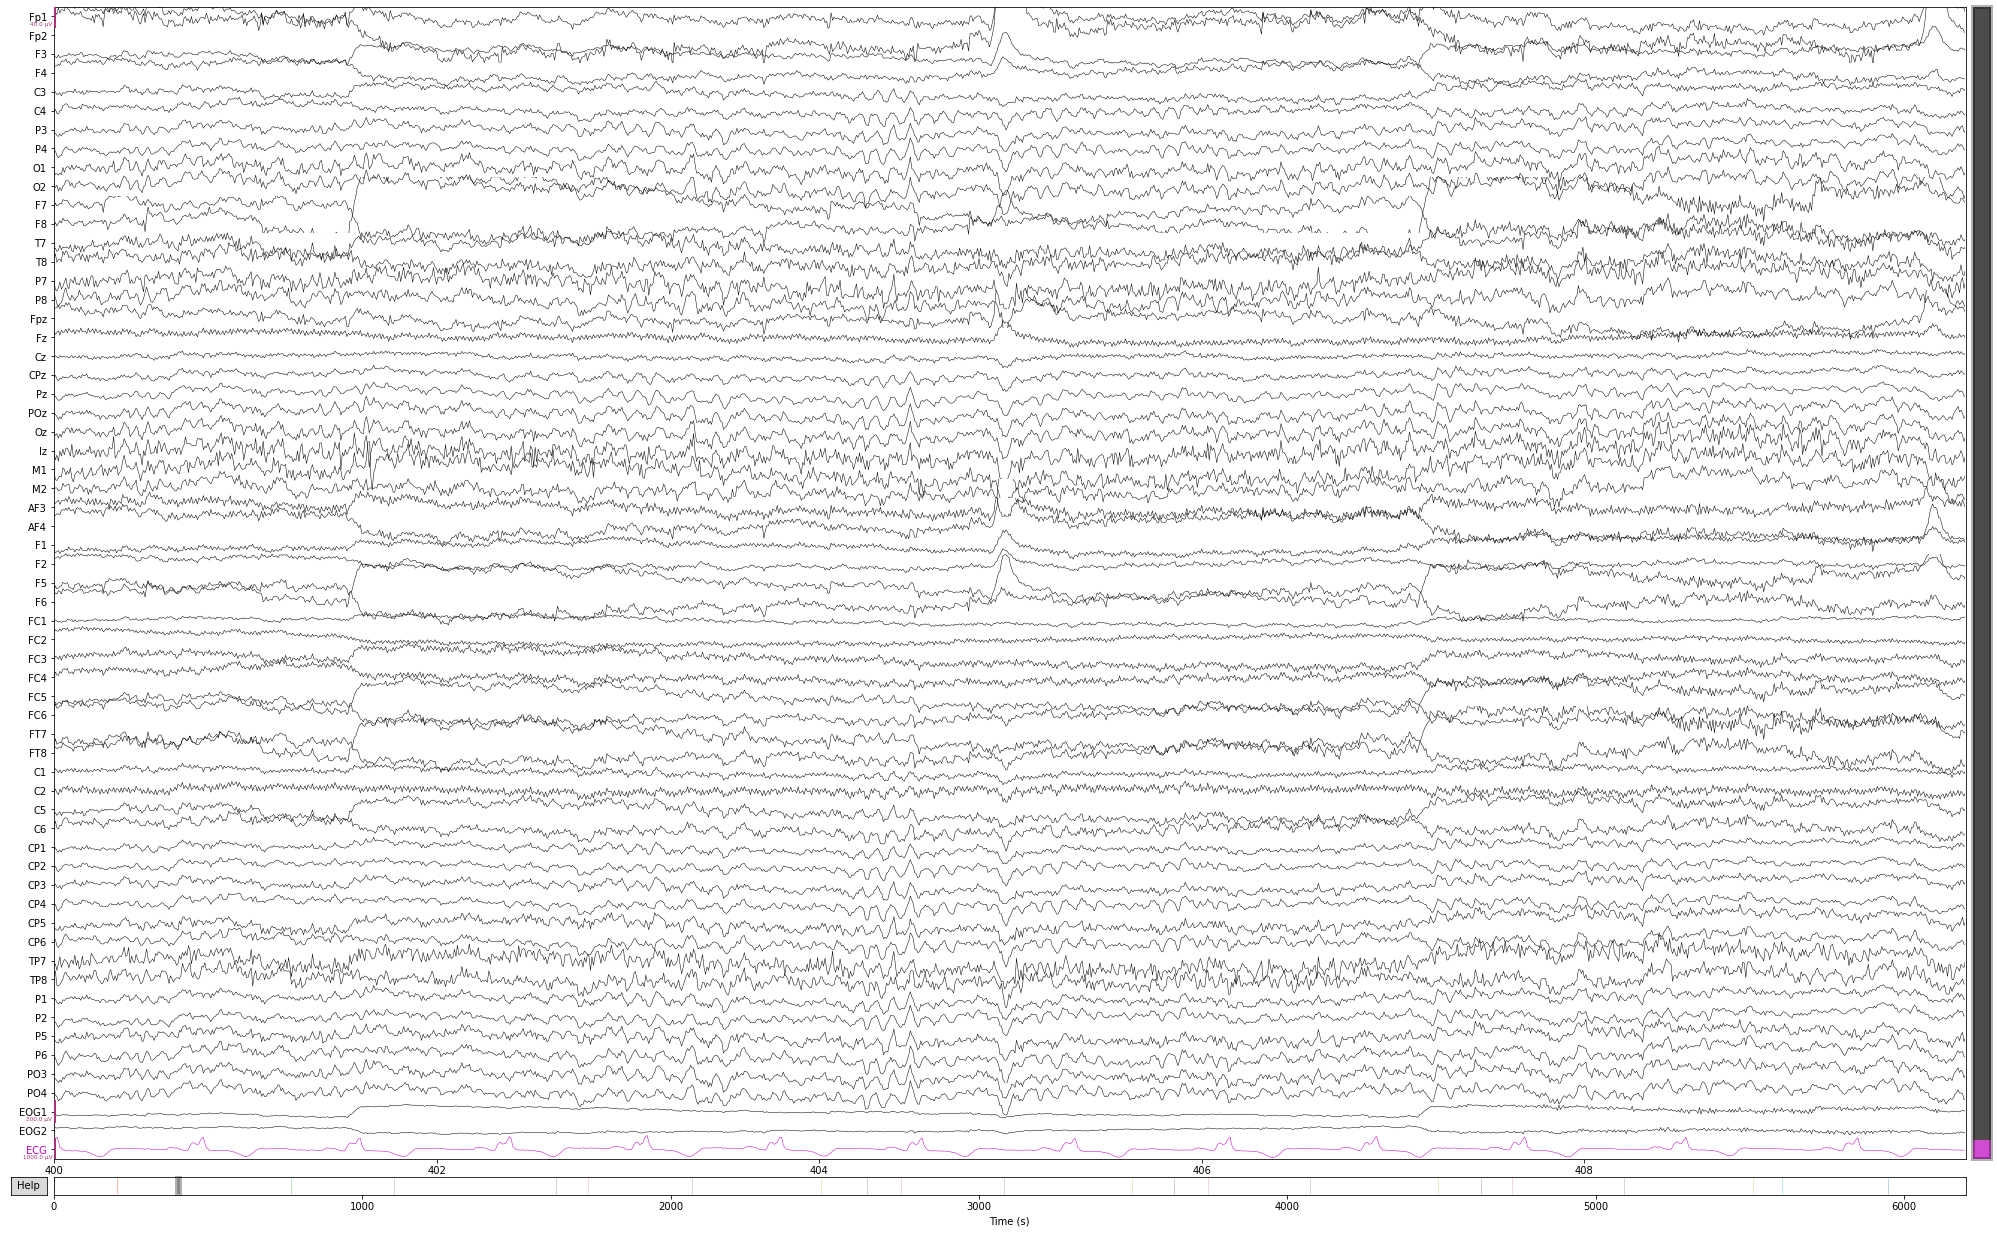

In [ ]:
# Raw signal traces
fig = raw.plot(start = 400, n_channels= 61, show=False)
fig.set_size_inches(30,20)
plt.show()

In [ ]:
# 2D topography
## constructing a layout with mne.channels.Layout

pos = mne.channels.make_standard_montage('easycap-M10')
pos.plot()

Brain Vision Data Exchange Header File Version 1.0
; Data created by the Vision Recorder

[Common Infos]
Codepage=UTF-8
DataFile=214811.eeg
MarkerFile=214811.vmrk
DataFormat=BINARY
; Data orientation: MULTIPLEXED=ch1,pt1, ch2,pt1 ...
DataOrientation=MULTIPLEXED
NumberOfChannels=61
; Sampling interval in microseconds
SamplingInterval=1000

[Binary Infos]
BinaryFormat=INT_16

[Channel Infos]
; Each entry: Ch<Channel number>=<Name>,<Reference channel name>,
; <Resolution in "Unit">,<Unit>, Future extensions..
; Fields are delimited by commas, some fields might be omitted (empty).
; Commas in channel names are coded as "\1".
Ch1=Fp1,,0.1,µV
Ch2=Fp2,,0.1,µV
Ch3=F3,,0.1,µV
Ch4=F4,,0.1,µV
Ch5=C3,,0.1,µV
Ch6=C4,,0.1,µV
Ch7=P3,,0.1,µV
Ch8=P4,,0.1,µV
Ch9=O1,,0.1,µV
Ch10=O2,,0.1,µV
Ch11=F7,,0.1,µV
Ch12=F8,,0.1,µV
Ch13=T7,,0.1,µV
Ch14=T8,,0.1,µV
Ch15=P7,,0.1,µV
Ch16=P8,,0.1,µV
Ch17=Fpz,,0.1,µV
Ch18=Fz,,0.1,µV
Ch19=Cz,,0.1,µV
Ch20=CPz,,0.1,µV
Ch21=Pz,,0.1,µV
Ch22=POz,,0.1,µV
Ch23=Oz,,0.1,µV
Ch24=Iz

## Remove line noise

Next cell opens the data collected from several subjects one-by-one and visualizes their power spectral density to inspect the intensity of the power line noise on data.
Running this cell will take a longer while.


<ipython-input-4-0b916bf594f1>:10: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(session_file, verbose= False)
<ipython-input-4-0b916bf594f1>:10: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(session_file, verbose= False)
<ipython-input-4-0b916bf594f1>:10: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(session_file, verbose= False)
<ipython-input-4-0b916bf594f1>:10: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(session_fi

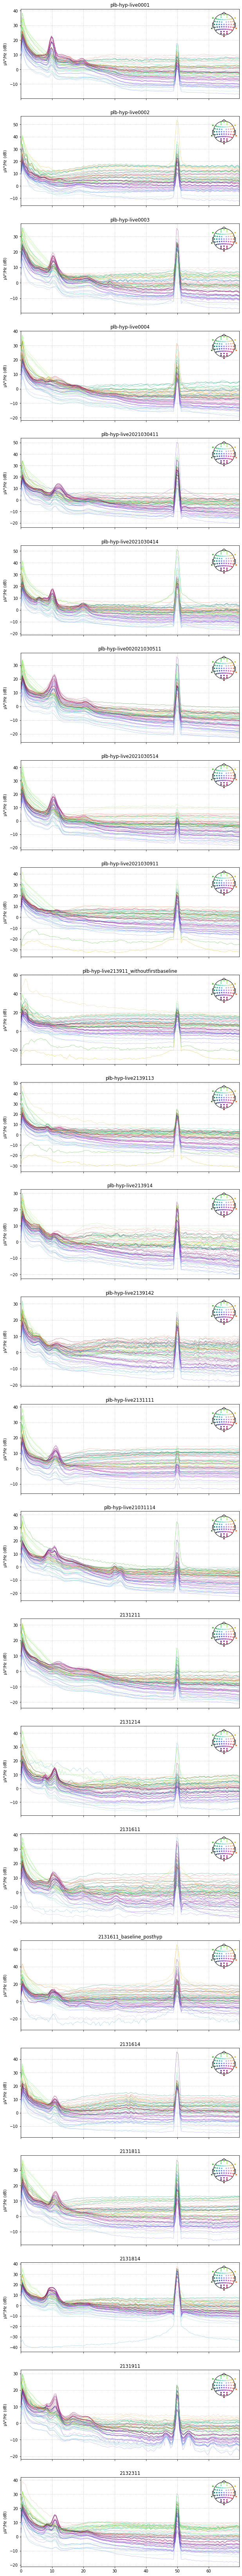

In [ ]:
# Open all the EEG data and visualize their power spectrum density
from pathlib import Path

sessions_dir = Path('/content/drive/MyDrive/Live Sessions/')
session_files = list(sessions_dir.glob('*.vhdr'))
n_subs = len(session_files)

fig, axes = plt.subplots(n_subs, 1, sharex= True, figsize = (10,n_subs * 5))
for i, session_file in enumerate(session_files):
  raw_temp = mne.io.read_raw_brainvision(session_file, verbose= False)
  raw_temp.plot_psd(fmax= 70, ax = axes[i], show= False, verbose = False) # MNE computes the PSD of raw data using the standard Welch’s method
  axes[i].set(title = session_file.stem)

plt.show()

In [ ]:
# Repair power line noise with notchfilter (Should try later Zapline of spectrum interpolation)
freqs = (50, 100, 150, 200)
raw_notch = raw.copy().notch_filter(freqs=freqs)
for title, data in zip(['Un', 'Notch '], [raw, raw_notch]):
    fig = data.plot_psd(fmax=250, average=True)
    fig.subplots_adjust(top=0.85)
    fig.suptitle('{}filtered'.format(title), size='xx-large', weight='bold')

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 sec)



## Filtering
Apply high-pass and low-pass filters at 0.3 Hz and 70 Hz respectively.


In [ ]:
# low-pass
raw.filter(l_freq= 0.3 , h_freq= None)

# high-pass
raw.filter(l_freq= None , h_freq= 70)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.3 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Filter length: 11001 samples (11.001 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 70 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 70.00 Hz
- Upper transition bandwidth: 17.50 Hz (-6 dB cutoff frequency: 78.75 Hz)
- Filter length: 189 samples (0.189 sec)



<RawBrainVision | 214611.eeg, 61 x 7893000 (7893.0 s), ~3.59 GB, data loaded>

## Event annotation

We choose six target segments here: baseline, four within-procedure experiences, and post-hypnosis experience. Next, we will create fixed length epochs within these time spans to prepare them for rejection of transient artifacts.

In [ ]:
# save the original annotations before modifying them
raw.annotations.save('saved-annotations.csv')

onset = raw.annotations.onset
# define a new set of annotations which includes 6 five-min-long segments
new_annot =  mne.Annotations(onset= [onset[2], onset[6], onset[6+4], onset[6+8], onset[6+12], onset[20]],
                             duration = [onset[3] - onset[2], onset[7] - onset[6], onset[7+4] - onset[6+4], onset[7+8] - onset[6+8], onset[7+12] - onset[6+12], onset[21] - onset[20]],
                             description = ['baseline','exp_1th','exp_2th','exp_3th','exp_4th','posthypno'])

raw.set_annotations(new_annot)

<RawBrainVision | 214611.eeg, 61 x 7893000 (7893.0 s), ~3.59 GB, data loaded>

Used Annotations descriptions: ['baseline', 'exp_1th', 'exp_2th', 'exp_3th', 'exp_4th', 'posthypno']
Not setting metadata
Not setting metadata
2355 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 2355 events and 701 original time points ...
0 bad epochs dropped


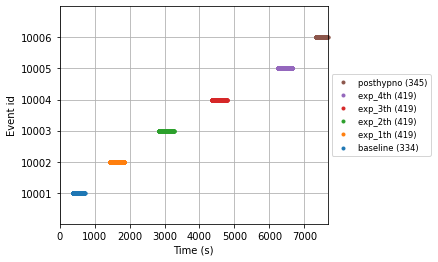

In [ ]:
# create fixed length (1s) epochs
events, event_dict = mne.events_from_annotations(raw, chunk_duration= 1)
epochs = mne.Epochs(raw, events, event_dict, preload= True)
fig = mne.viz.plot_events(events, sfreq=raw.info['sfreq'],
                          first_samp=raw.first_samp, event_id=event_dict)
fig.subplots_adjust(right=0.7)  # make room for legend

Now that we have the epoched data, we will use Autoreject package to annotate bad segments.

## Autoreject
We use [Autoreject algorithm](https://autoreject.github.io/) (local) to automatically detect and remove bad epochs due to transiant artifacts. Autoreject is an unsupervised algorithm which learn the rejection threshold for each channel in each subject.



In [ ]:
# mark bad segments using Autoreject algorithm (Jas et al., 2017)
from autoreject import AutoReject
ar = AutoReject()
epochs_clean = ar.fit_transform(epochs)

Running autoreject on ch_type=eeg


Computing thresholds ...: 100%|██████████| 58/58 [20:15<00:00, 20.96s/it]


Repairing epochs:   0%|          | 0/2355 [00:00<?, ?it/s]

Repairing epochs:   1%|          | 27/2355 [00:00<00:08, 267.87it/s]

Repairing epochs:   2%|▏         | 51/2355 [00:00<00:08, 258.38it/s]

Repairing epochs:   3%|▎         | 75/2355 [00:00<00:09, 251.03it/s]

Repairing epochs:   4%|▍         | 99/2355 [00:00<00:09, 246.42it/s]

Repairing epochs:   5%|▌         | 123/2355 [00:00<00:09, 244.16it/s]

Repairing epochs:   6%|▋         | 149/2355 [00:00<00:08, 246.59it/s]

Repairing epochs:   7%|▋         | 175/2355 [00:00<00:08, 248.24it/s]

Repairing epochs:   8%|▊         | 199/2355 [00:00<00:08, 245.14it/s]

Repairing epochs:  10%|▉         | 225/2355 [00:00<00:08, 246.77it/s]

Repairing epochs:  11%|█         | 249/2355 [00:01<00:08, 242.64it/s]

Repairing epochs:  12%|█▏        | 274/2355 [00:01<00:08, 244.27it/s]

Repairing epochs:  13%|█▎        | 300/2355 [00:01<00:08, 247.88it/s]

Repairing epochs





Estimated consensus=0.50 and n_interpolate=4




Repairing epochs:   0%|          | 0/2355 [00:00<?, ?it/s]

Repairing epochs:   0%|          | 5/2355 [00:00<00:48, 48.02it/s]

Repairing epochs:   0%|          | 9/2355 [00:00<00:55, 42.59it/s]

Repairing epochs:   1%|          | 13/2355 [00:00<00:58, 39.88it/s]

Repairing epochs:   1%|          | 17/2355 [00:00<01:01, 37.87it/s]

Repairing epochs:   1%|          | 21/2355 [00:00<01:02, 37.12it/s]

Repairing epochs:   1%|          | 24/2355 [00:00<01:13, 31.82it/s]

Repairing epochs:   1%|          | 27/2355 [00:00<01:16, 30.30it/s]

Repairing epochs:   1%|▏         | 30/2355 [00:00<01:18, 29.65it/s]

Repairing epochs:   1%|▏         | 33/2355 [00:01<01:27, 26.65it/s]

Repairing epochs:   2%|▏         | 36/2355 [00:01<01:34, 24.46it/s]

Repairing epochs:   2%|▏         | 39/2355 [00:01<01:32, 25.07it/s]

Repairing epochs:   2%|▏         | 43/2355 [00:01<01:24, 27.25it/s]

Repairing epochs:   2%|▏         | 46/2355 [00:01<01:27, 26.39it/s]

Repairing epochs:   2%|▏         | 49/2355 

Dropped 840 epochs: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 28, 29, 31, 34, 35, 36, 37, 38, 39, 40, 41, 42, 46, 51, 52, 56, 57, 71, 72, 73, 89, 108, 109, 167, 196, 209, 210, 211, 212, 216, 237, 238, 241, 253, 264, 322, 323, 324, 325, 326, 328, 329, 330, 331, 332, 333, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 373, 374, 375, 376, 377, 380, 381, 385, 387, 393, 394, 395, 400, 408, 410, 417, 418, 421, 422, 426, 448, 451, 452, 454, 456, 459, 466, 467, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 489, 491, 494, 497, 498, 499, 500, 501, 502, 504, 505, 507, 508, 509, 510, 515, 516, 518, 520, 521, 524, 526, 527, 530, 531, 534, 535, 536, 541, 544, 545, 553, 554, 560, 564, 565, 566, 585, 586, 592, 595, 599, 600, 602, 613, 615, 638, 639, 646, 653, 656, 657, 658, 659, 660, 661, 673, 674, 677, 679, 680, 681, 682, 683, 684, 685, 692, 700, 703, 704, 705, 706, 707, 70

## Repair ECG and EOG artifacts with ICA

### Biological artifacts detection

As a preliminary step to data cleanup, let's visualize the extent to which the data has been impacted by various types of noise. This section will determine whether specific amendments should be made to the data, based on detecting biological artifacts.

In [ ]:
# heartbeat artifact
ecg_epochs = mne.preprocessing.create_ecg_epochs(raw)
# plot event related potentials
ecg_epochs.plot_image(picks = ['Fp1','Fp2'],combine='mean')

Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 10000 samples (10.000 sec)

Number of ECG events detected : 11091 (average pulse 84 / min.)
Not setting metadata
Not setting metadata
11091 matching events found
No baseline correction applied
Loading data for 11091 events and 1001 original time points ...
1 bad epochs dropped
Not setting metadata
Not setting metadata
11090 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


Applying baseline correction (mode: mean)


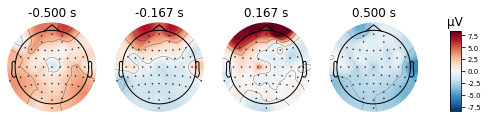

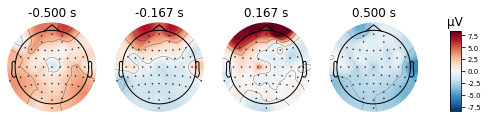

In [ ]:
avg_ecg_epochs = ecg_epochs.average().apply_baseline((-0.5, -0.2))
avg_ecg_epochs.plot_topomap()

Using EOG channels: EOG1, EOG2
EOG channel index for this subject is: [26 27]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 53 significant peaks
Number of EOG events detected: 53
Not setting metadata
Not setting metadata
53 matching events found
Applying baseline correction (mode: mean)
Loading data for 53 events and 1001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
53 

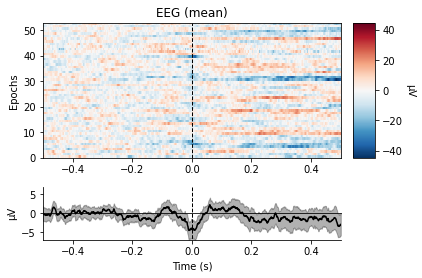

No projector specified for this dataset. Please consider the method self.add_proj.


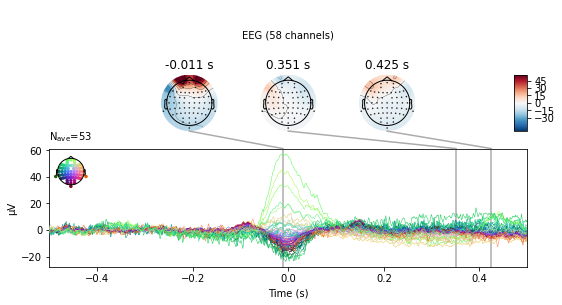

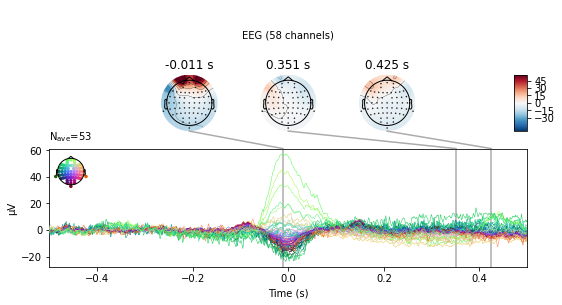

In [ ]:
# Ocular artifacts
eog_epochs = mne.preprocessing.create_eog_epochs(raw, baseline=(-0.5, -0.2))
eog_epochs.plot_image(combine='mean')
eog_epochs.average().plot_joint()

In [ ]:
ica = ICA(n_components= 58, max_iter='auto', random_state=97)
ica.fit(raw)

## Format and validate timing percision

In [ ]:
# Rename the file if needed and upload them in Google drive
data_dir = '/content/drive/MyDrive/rename_temporary'
vhdr_file = op.join(data_dir, 'Confusion.vhdr')
vhdr_file_renamed = op.join(data_dir, 'hypnotist_confindu.vhdr')
copyfile_brainvision(vhdr_file, vhdr_file_renamed, verbose=True)

# Check that MNE-Python can read in both, the original as well as the renamed
# data (two files: their contents are the same apart from the name)
raw = mne.io.read_raw_brainvision(vhdr_file)
raw_renamed = mne.io.read_raw_brainvision(vhdr_file_renamed)

In [ ]:
# Check timing synchronization between EEG triggers and OpenSesame timestamps
## read csv file as pandas and find duration between timestamps
subject = pd.read_csv('/content/drive/MyDrive/plb_hyp_eeg_test/subject-1.csv')
subject = subject.tail(1)
triggers = [c for c in subject.columns if 'timestamp_' in c]
data = subject[triggers]
diff_csv = pd.to_datetime(data.iloc[0]).diff()

# trigInx = subject.columns.get_loc("timestamp_trigger_1")
# for i in range(5):
#   data = subject.iloc[:,trigInx:trigInx+i]
# data.insert(0,"timestamp_trigger_start",subject.loc[:,"timestamp_trigger_start"])

## read EEG marker files and calculate difference between timestamps
raw = mne.io.read_raw_brainvision('/content/drive/MyDrive/Live Sessions/2141611.vhdr')
events, event_ids = mne.events_from_annotations(raw)

diff_eeg = np.ediff1d(events[:,0])
# display(diff_csv)
display(pd.to_timedelta(diff_eeg,'ms').to_frame())

Extracting parameters from /content/drive/MyDrive/Live Sessions/2141611.vhdr...
Setting channel info structure...
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S  7', 'Stimulus/S  8', 'Stimulus/S  9']


<ipython-input-4-a4e1e218e190>:1: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision('/content/drive/MyDrive/Live Sessions/2141611.vhdr')


0
0 days 00:01:10.724000 0 days 00:01:10.724000
0 days 00:00:00.001000 0 days 00:00:00.001000
0 days 00:10:34.047000 0 days 00:10:34.047000
0 days 00:05:33.586000 0 days 00:05:33.586000
0 days 00:08:27.601000 0 days 00:08:27.601000
0 days 00:01:48.206000 0 days 00:01:48.206000
0 days 00:06:03.294000 0 days 00:06:03.294000
0 days 00:06:56.383000 0 days 00:06:56.383000
0 days 00:03:16.626000 0 days 00:03:16.626000
0 days 00:01:42.767000 0 days 00:01:42.767000
0 days 00:05:30.906000 0 days 00:05:30.906000
0 days 00:06:56.383000 0 days 00:06:56.383000
0 days 00:08:35.911000 0 days 00:08:35.911000
0 days 00:01:48.206000 0 days 00:01:48.206000
0 days 00:05:35.624000 0 days 00:05:35.624000
0 days 00:06:56.383000 0 days 00:06:56.383000
0 days 00:05:18.389000 0 days 00:05:18.389000
0 days 00:01:42.762000 0 days 00:01:42.762000
0 days 00:05:37.384000 0 days 00:05:37.384000
0 days 00:06:56.383000 0 days 00:06:56.383000
0 days 00:07:41.190000 0 days 00:07:41.190000
0 days 00:05:42.694000 0 days 00:05:42.694000

# References
 - [MNE Python tutorials](https://mne.tools/stable/index.html)
 - Jas, M., Larson, E., Engemann, D. A., Leppäkangas, J., Taulu, S., Hämäläinen, M., & Gramfort, A. (2018). A reproducible MEG/EEG group study with the MNE software: recommendations, quality assessments, and good practices. Frontiers in neuroscience, 12, 530.
 - Jas, M., Engemann, D. A., Bekhti, Y., Raimondo, F., & Gramfort, A. (2017). Autoreject: Automated artifact rejection for MEG and EEG data. NeuroImage, 159, 417-429.
